## Cleaning the Maestro Dataset

In [9]:
#from music21 import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# Library good for displaying music and audio
#import librosa.display
import mir_eval.display
import pickle
import json
import seaborn as sns
from tqdm import tqdm
import pretty_midi as pm
from collections import defaultdict

In [10]:
df_meta = pd.read_csv('data/maestro_meta.csv')

FileNotFoundError: [Errno 2] File b'data/maestro_meta.csv' does not exist: b'data/maestro_meta.csv'

In [11]:
df_meta.head()

NameError: name 'df_meta' is not defined

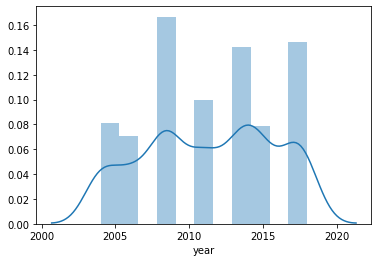

In [3]:
sns.distplot(df_meta['year'])

In [4]:
df_meta.columns

Index(['canonical_composer', 'canonical_title', 'split', 'year',
       'midi_filename', 'audio_filename', 'duration'],
      dtype='object')

In [5]:
df_meta.loc[if 'Chopin' in df_meta['canonical_composer'], 'canonical_title']

SyntaxError: invalid syntax (<ipython-input-5-93bfc4689e30>, line 1)

In [7]:
%matplotlib inline

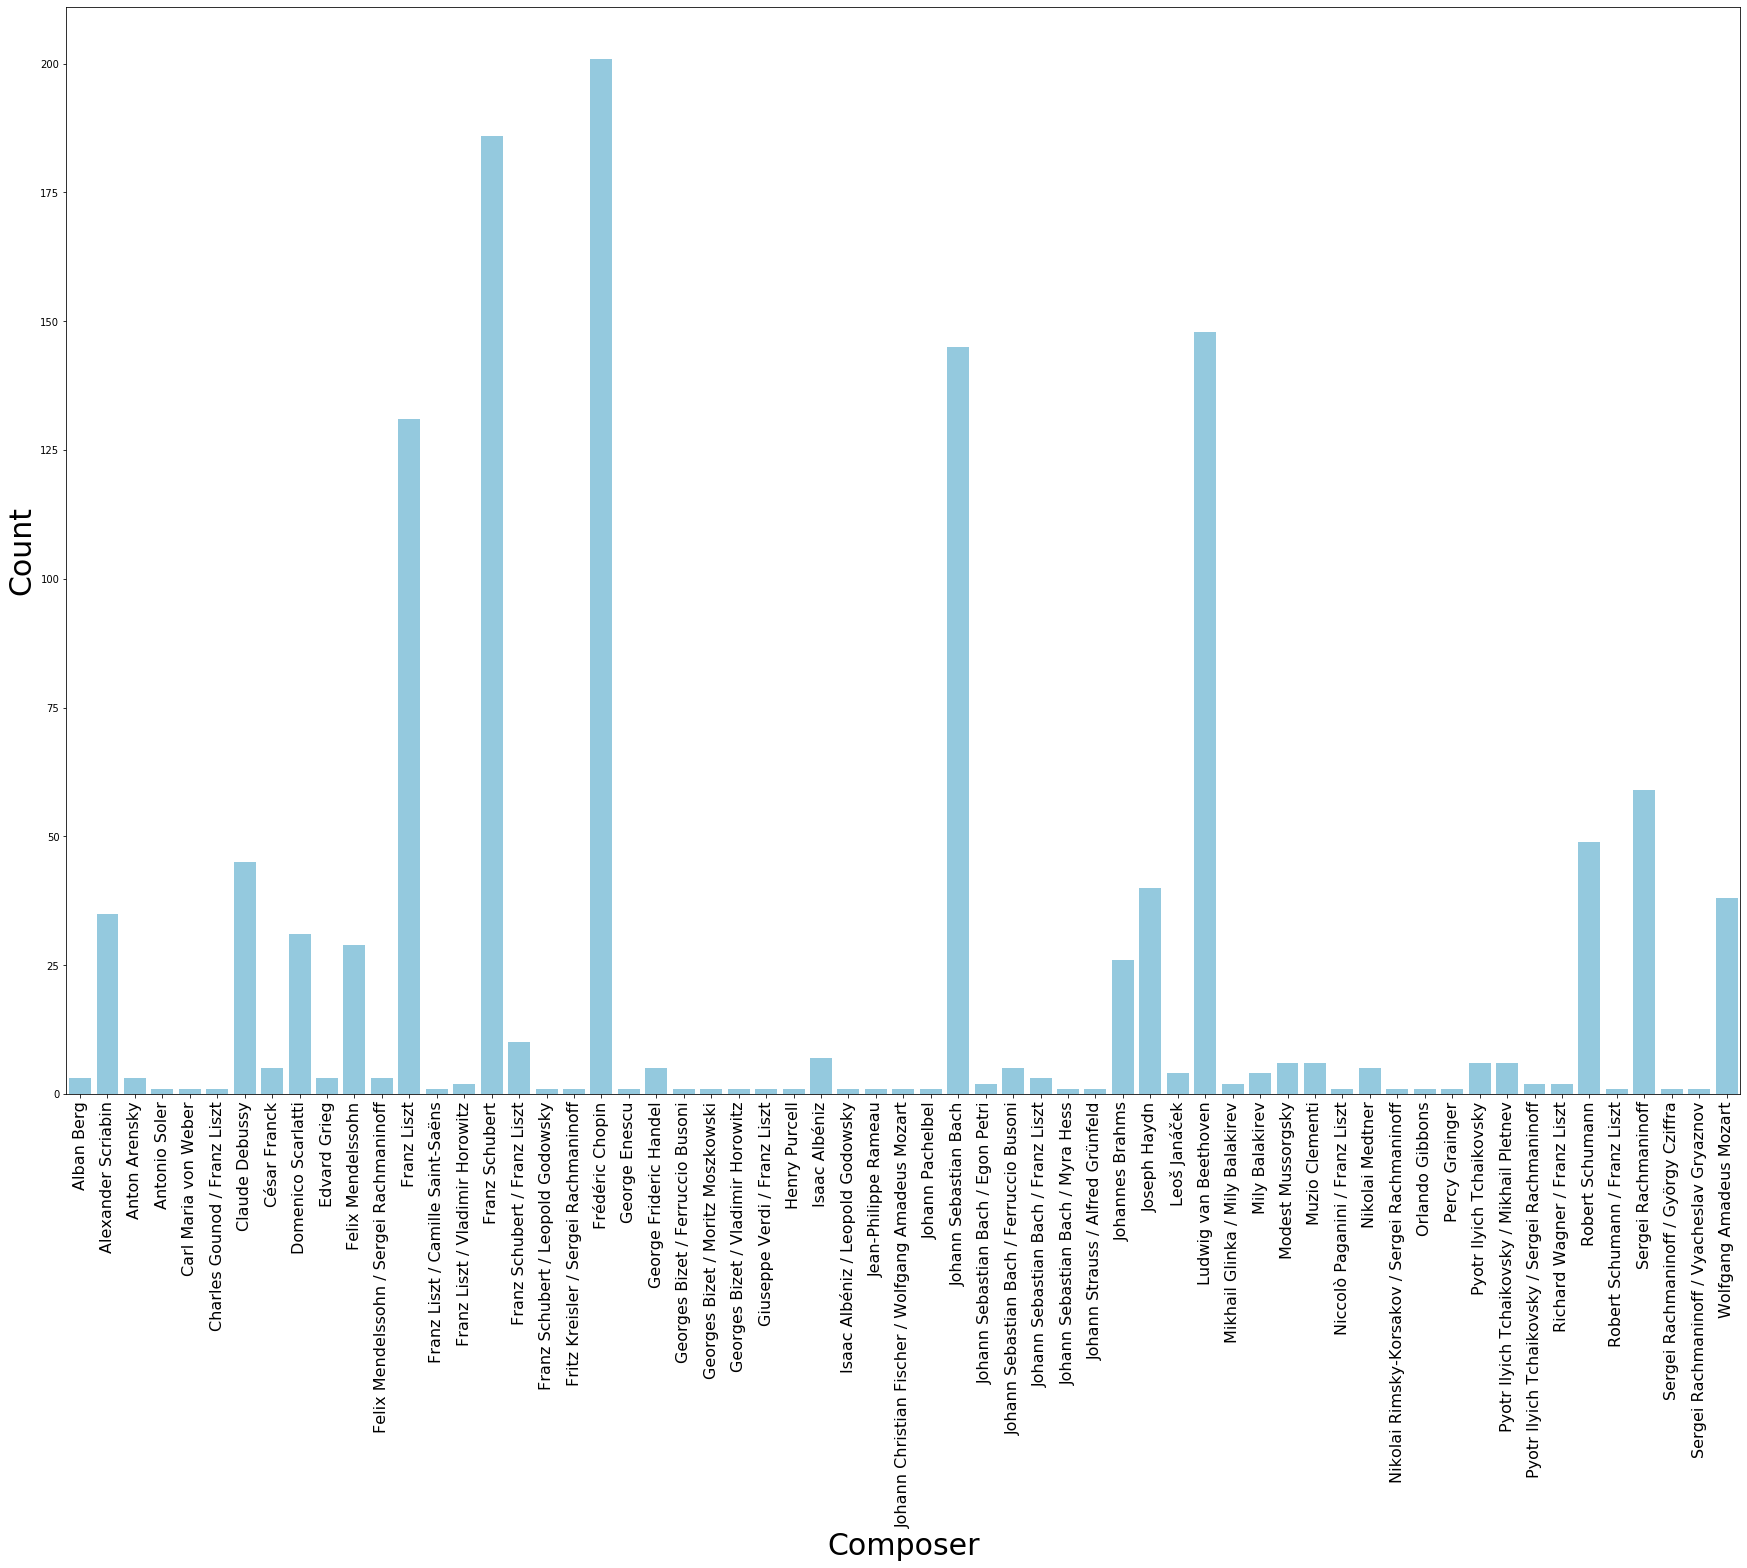

In [8]:
plt.figure(figsize = (30,20))
locs, labels = plt.xticks()            # Get locations and labels
plt.xticks(locs, labels, rotation = 'vertical', size = 16)  # Set locations and labels
sns.countplot(df_meta['canonical_composer'], color = 'skyblue')
plt.xlabel(xlabel = 'Composer', size = 30)
plt.ylabel(ylabel = 'Count', size = 30)
plt.show()

In [9]:
path = 'data/maestro/2018'

In [10]:
filename = os.listdir(path)[0]

In [8]:
# Checking midi file with music21
score = converter.parse(path + '/' + filename, format = 'midi')

KeyboardInterrupt: 

In [22]:
[str(p) for p in score.parts[0].pitches[0:10]]

['D5', 'D2', 'C#5', 'C#2', 'B-1', 'B4', 'G5', 'G2', 'F#5', 'F#2']

In [11]:
mid_pretty = pm.PrettyMIDI(path + '/' + filename)

Pretty_midi is **far** faster than music21

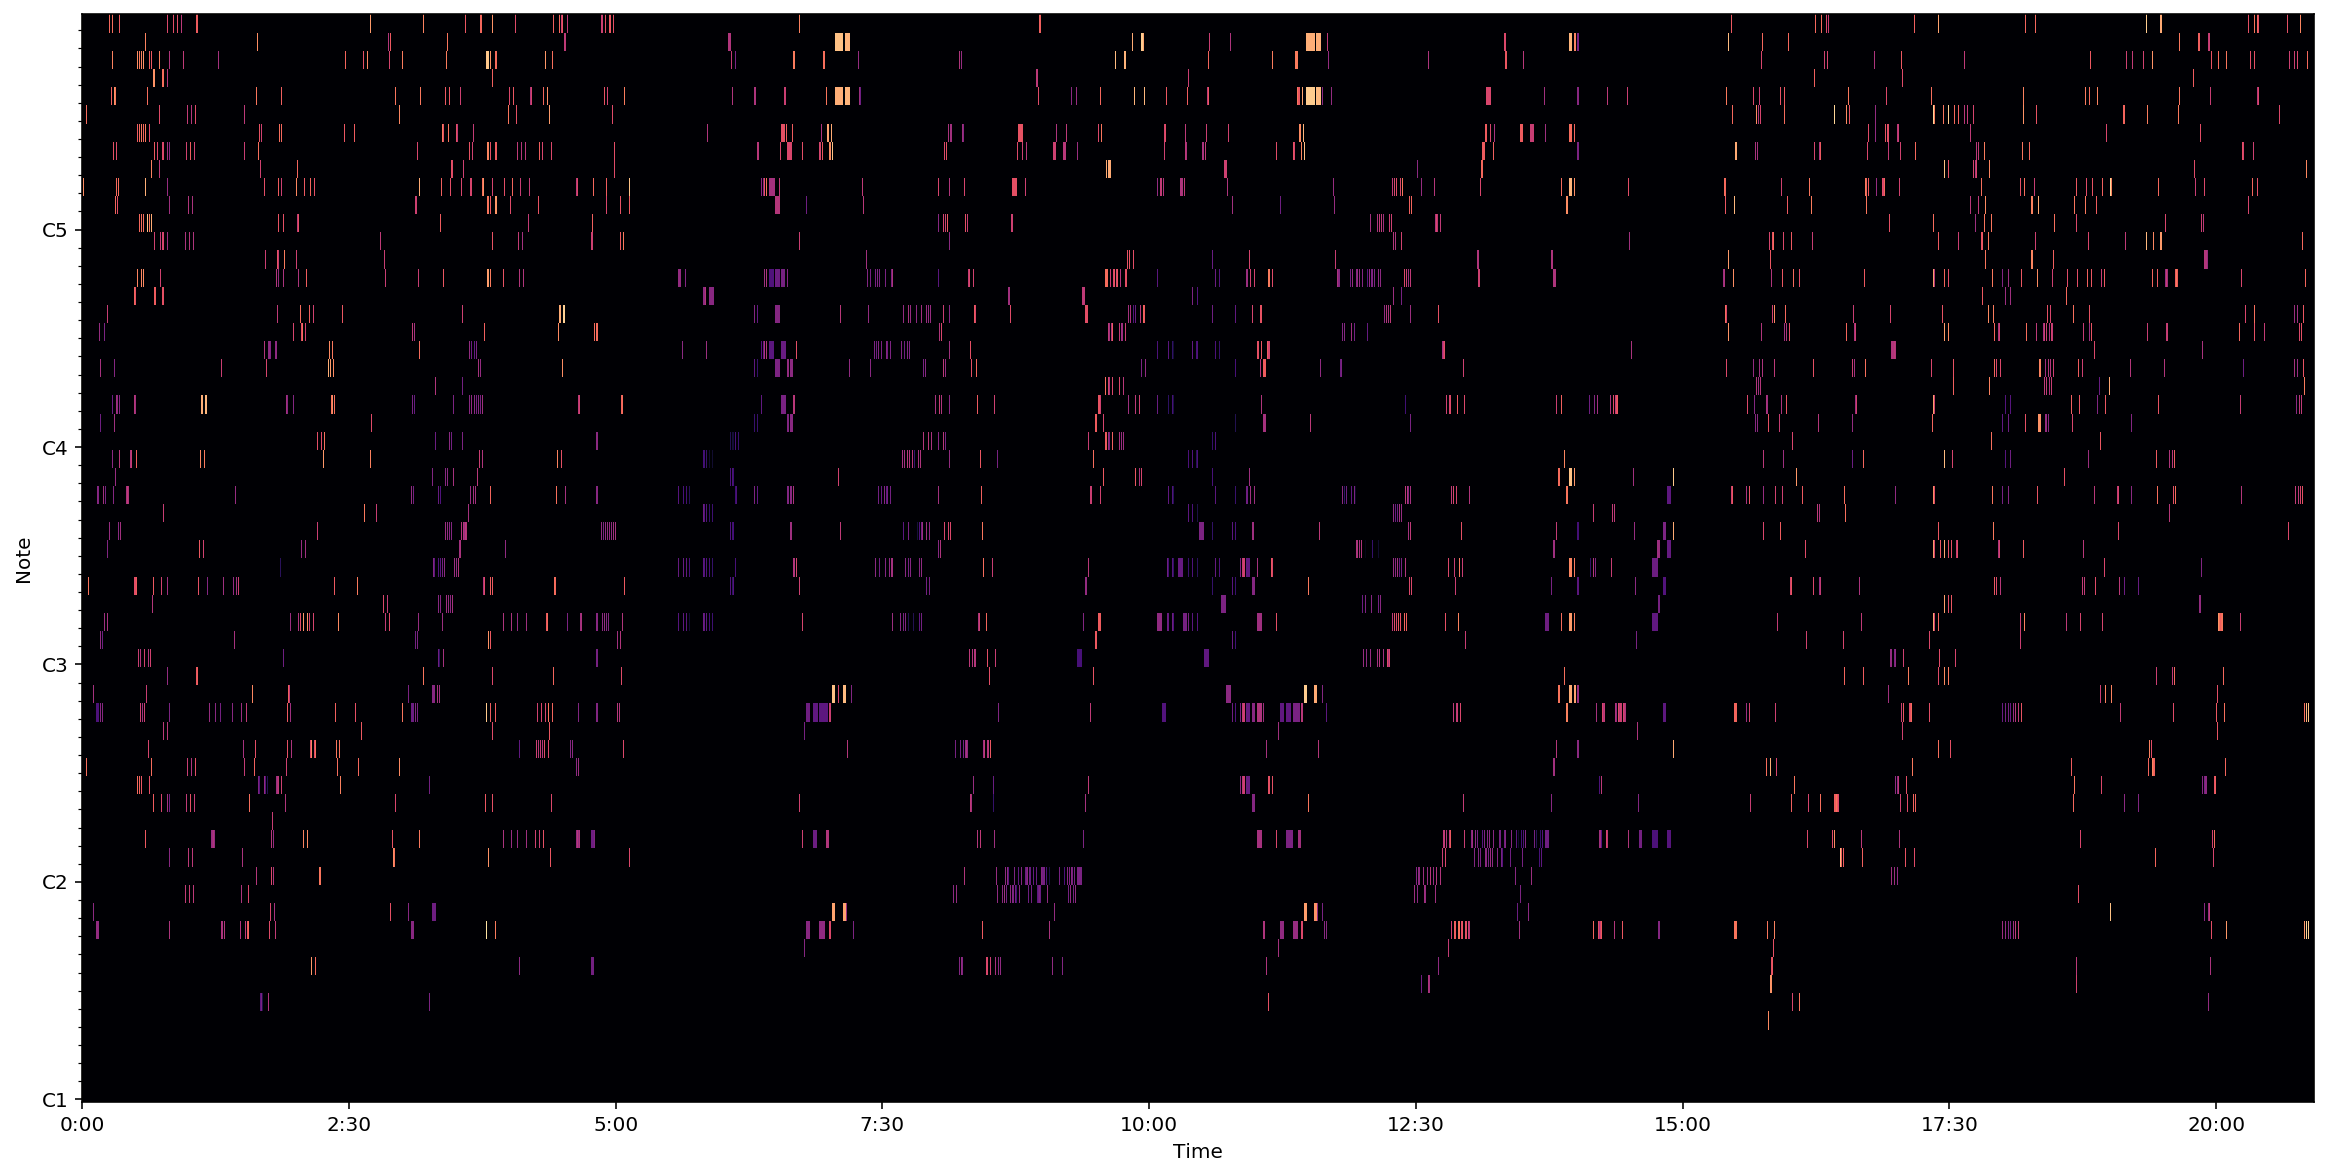

In [38]:
def plot_piano_roll(mid_pretty, start_pitch, end_pitch, fs=100):
    librosa.display.specshow(mid_pretty.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(20, 10))
plot_piano_roll(mid_pretty, 24, 84)

In [22]:
# Let's look at what's in this MIDI file
print('There are {} time signature changes'.format(len(mid_pretty.time_signature_changes)))
print('There are {} instruments'.format(len(mid_pretty.instruments)))
print('Instrument has {} notes'.format(len(mid_pretty.instruments[0].notes)))
print('Instrument has {} pitch bends'.format(len(mid_pretty.instruments[0].pitch_bends)))
print('Instrument has {} control changes'.format(len(mid_pretty.instruments[0].control_changes)))

There are 1 time signature changes
There are 1 instruments
Instrument has 12190 notes
Instrument has 0 pitch bends
Instrument has 17287 control changes


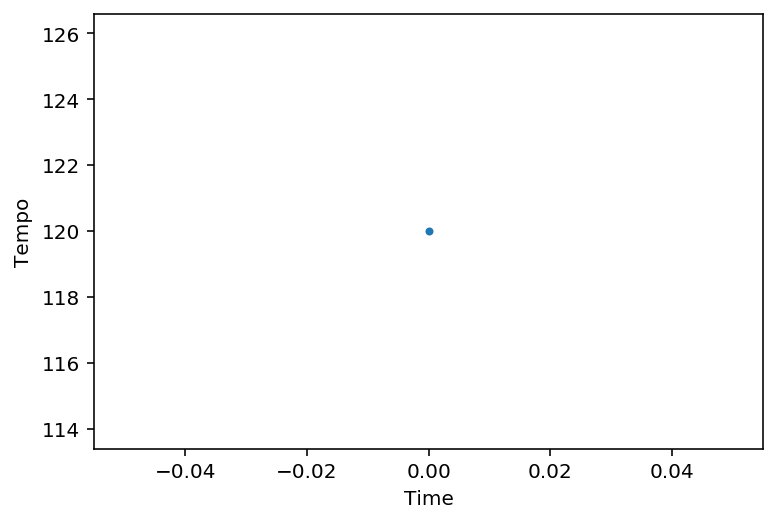

In [41]:
# Plot the tempo changes over time
# Many MIDI files won't have more than one tempo change event,
times, tempo_changes = mid_pretty.get_tempo_changes()
plt.plot(times, tempo_changes, '.')
plt.xlabel('Time')
plt.ylabel('Tempo');

No tempo changes

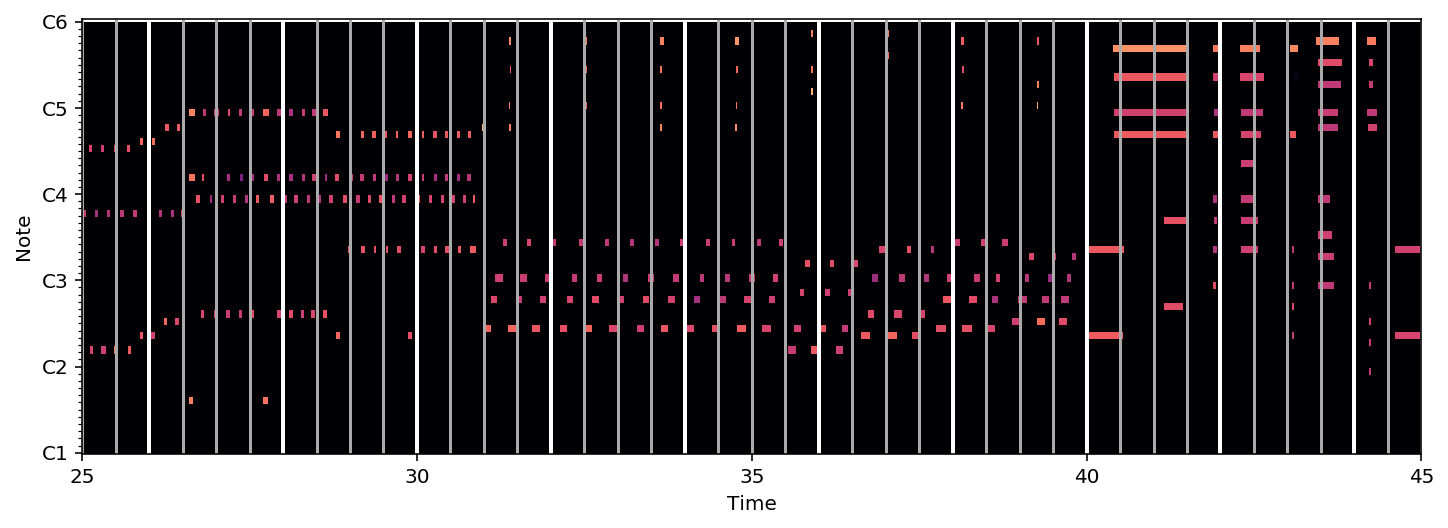

In [45]:
beats = mid_pretty.get_beats()
downbeats = mid_pretty.get_downbeats()
# Plot piano roll
plt.figure(figsize=(12, 4))
plot_piano_roll(mid_pretty, 24, 84)
ymin, ymax = plt.ylim()
# Plot beats as grey lines, downbeats as white lines
mir_eval.display.events(beats, base=ymin, height=ymax, color='#AAAAAA')
mir_eval.display.events(downbeats, base=ymin, height=ymax, color='#FFFFFF', lw=2)
# Only display 20 seconds for clarity
plt.xlim(25, 45);

Text(0, 0.5, 'Proportion')

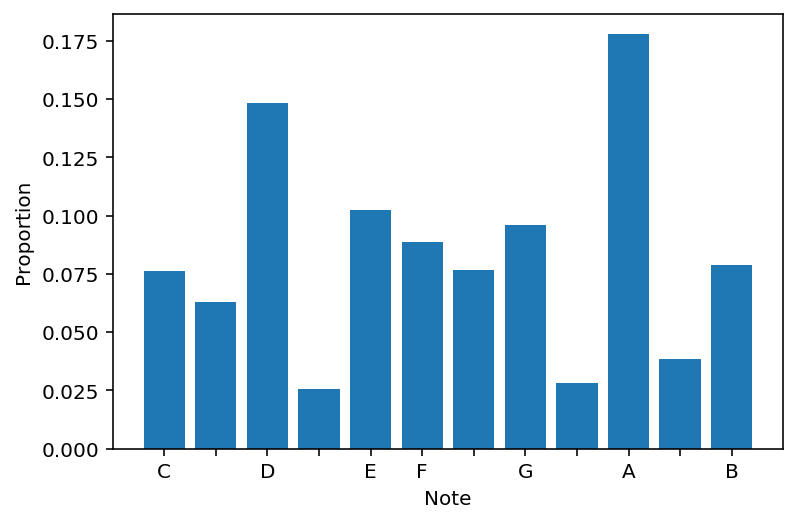

In [47]:
# Plot a pitch class distribution - sort of a proxy for key
plt.bar(np.arange(12), mid_pretty.get_pitch_class_histogram());
plt.xticks(np.arange(12), ['C', '', 'D', '', 'E', 'F', '', 'G', '', 'A', '', 'B'])
plt.xlabel('Note')
plt.ylabel('Proportion')

In [52]:
mid_pretty.estimate_tempo()

202.57288292458153

array([[ 261.,    6.,  116.,  119.,  112.,  100.,  105.,  209.,    3.,
         178.,   69.,  192.],
       [   9.,  270.,  181.,    7.,  211.,   13.,   27.,   62.,    5.,
         226.,   34.,  116.],
       [ 145.,  292.,  835.,   33.,  299.,  261.,  258.,  188.,  143.,
         404.,   91.,  199.],
       [ 138.,   13.,   36.,   82.,   38.,   25.,  103.,   50.,    2.,
          48.,    8.,   26.],
       [ 114.,  182.,  264.,   31.,  608.,   76.,  247.,  250.,   44.,
         208.,   20.,   97.],
       [  85.,   16.,  261.,   34.,   86.,  571.,   15.,  162.,   16.,
         259.,   80.,   58.],
       [ 114.,   34.,  212.,   41.,  218.,   11.,  415.,  128.,   49.,
         404.,   17.,   58.],
       [ 172.,   63.,  192.,   36.,  196.,  161.,  148.,  458.,    8.,
         235.,   61.,  167.],
       [   2.,    7.,  124.,    0.,   61.,   58.,   22.,   13.,  114.,
          86.,    2.,   67.],
       [ 263.,  190.,  402.,   71.,  252.,  266.,  363.,  250.,   66.,
        1195.,   58.

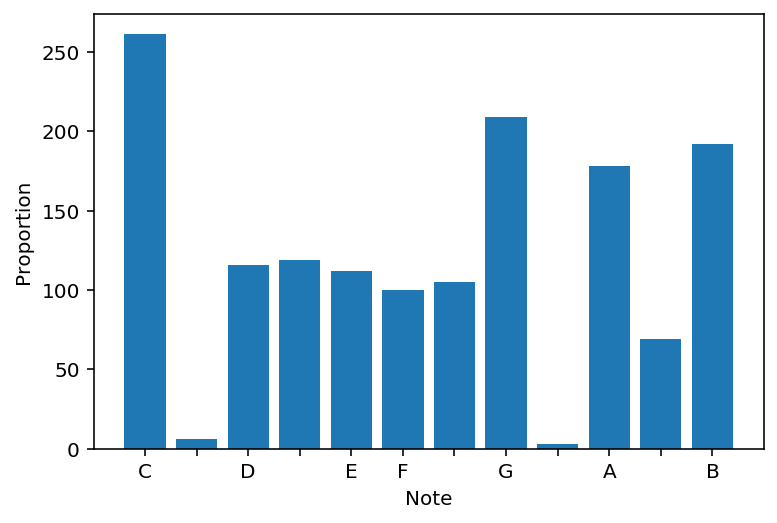

In [55]:
plt.bar(np.arange(12), mid_pretty.get_pitch_class_transition_matrix()[0]);
plt.xticks(np.arange(12), ['C', '', 'D', '', 'E', 'F', '', 'G', '', 'A', '', 'B'])
plt.xlabel('Note')
plt.ylabel('Proportion')
mid_pretty.get_pitch_class_transition_matrix()

In [12]:
piano_midi = mid_pretty.instruments[0] # Get the piano channels
piano_roll = piano_midi.get_piano_roll()
# A piano roll array has dimensions of (notes, time)

In [13]:
piano_midi.notes[0:10]

[Note(start=1.032552, end=1.226562, pitch=74, velocity=86),
 Note(start=1.044271, end=1.246094, pitch=38, velocity=77),
 Note(start=1.269531, end=1.309896, pitch=34, velocity=64),
 Note(start=1.239583, end=1.316406, pitch=73, velocity=69),
 Note(start=1.240885, end=1.324219, pitch=37, velocity=64),
 Note(start=1.273438, end=1.343750, pitch=71, velocity=71),
 Note(start=1.347656, end=1.394531, pitch=69, velocity=76),
 Note(start=1.324219, end=1.397135, pitch=35, velocity=64),
 Note(start=1.352865, end=1.410156, pitch=33, velocity=77),
 Note(start=1.533854, end=1.572917, pitch=79, velocity=76)]

In [14]:
piano_roll.shape

(128, 125515)

In [13]:
test = []
for i,note in enumerate(piano_roll):
    for time, strike in enumerate(note):
        if strike != 0:
            test.append(strike)

KeyboardInterrupt: 

The piano roll is an array of shape (notes, time) or (128, time) 

In [79]:
# Convert piano roll to a dictionary of times
notes_time = defaultdict(list)
for note,times in enumerate(piano_roll):
    notes_time[note] = [time for time,strike in enumerate(times) if int(strike) != 0]
    # This dictionary gives me the times when a note is struck paired with the note.

In [80]:
# I want a dictionary of key:time, value: notes
time_notes = defaultdict(list)
for note, times in tqdm(notes_time.items()):
    for time in times:
        time_notes[time].append(note)

100%|██████████| 128/128 [00:00<00:00, 860.92it/s]


In [81]:
# Starting time with notes
min([key for key in time_notes])

103

In [82]:
# Ending time with notes
max([key for key in time_notes])

125458

This dictionary function was pretty fast, so I feel good about it

In [83]:
# Now convert values in dictionary to strings
for time, notes in time_notes.items():
    if len(notes) == 1:
        time_notes[time] = str(notes[0])
    else:
        notes = [str(note) for note in notes]
        time_notes[time] = ','.join(notes)

In [84]:
time_notes

defaultdict(list,
            {94843: '28',
             94844: '28',
             94845: '28,71',
             94846: '28,71',
             94847: '28,67,71',
             94848: '28,67,71',
             94849: '28,67,71',
             94850: '28,67,71',
             94851: '28,67',
             94852: '28,67',
             94853: '28,67',
             94854: '28,67',
             94855: '28,61,67',
             94856: '28,61',
             94857: '28,61',
             94858: '28,61',
             94859: '28,61',
             94860: '28,61',
             94861: '28,61',
             94862: '28',
             94863: '28,30',
             94864: '28,30,71',
             94865: '28,30,71',
             94866: '28,30,67,71',
             94867: '28,30,67,71',
             94868: '28,30,67,71',
             94869: '28,30,67,71',
             94870: '28,30,67',
             94871: '28,30,67',
             94872: '28,30,67',
             94873: '28,30',
             103455: '28,40',
        

In [15]:
# Making a sliding scale of note sequences
def input_target_seq(dict_time_notes, seq_len = 50):
    # Get the starting and ending time points with notes
    start, end = sorted(list(time_notes.keys()))[0], sorted(list(time_notes.keys()))[-1]
    lst_train, lst_target = [], []
    flag_target_append = False
    # Iterate through all of the timepoints in between start and end
    for ind, time in enumerate(range(start, end)):
        window_train, window_target = [], []
        start_ind = 0
        
        # If the ind is in the first window
        if ind < seq_len: # ind = 0 < 50
            # Change window start to sequence length (window) - 1
            start_ind = seq_len - ind - 1 #start ind = 50 - 0 -1 = 49
            for i in range(start_ind): # 0 - 49
                window_train.append('e')  # Adding e for every item in start list
                flag_target_append = True
        
        for i in range(start_ind, seq_len): # 49 - 50
            # Set the index to 
            ind = time - (seq_len - i - 1) # 103 - (50 - 49 - 1) = 103
            if ind in dict_time_notes:
                window_train.append(dict_time_notes[ind])
            else:
                window_train.append('e')
        
        if time+1 in dict_time_notes:
            window_target.append(dict_time_notes[time+1])
        else:
            window_target.append('e')
        lst_train.append(window_train)
        lst_target.append(window_target)
        
    return lst_train, lst_target
            

In [16]:
def dict_note_index(time_notes):
    dict_index = defaultdict(int)
    dict_index['e'] = 0
    i = 1
    for time, notes in time_notes.items():
        if notes not in dict_index:
            dict_index[notes] = i
            i += 1
        else:
            pass
    return dict_index

In [ ]:
df['col'] = df['col'].map(dict)

In [17]:
def notes_to_index(lst_train, lst_target, dict_index):
    lst_train_ind, lst_target_ind = [], []
    for wind_train, note_target in zip(lst_train, lst_target):
        lst_train_wind = []
        lst_target_ind.append(dict_index[note_target[0]])
        for note_train in wind_train:
            lst_train_wind.append(dict_index[note_train])
        lst_train_ind.append(lst_train_wind)
    return lst_train_ind, lst_target_ind

In [18]:
dict_index = dict_note_index(time_notes)

NameError: name 'time_notes' is not defined

In [47]:
lst_train, lst_target = input_target_seq(time_notes)

In [41]:
print(len(lst_train))
print(len(lst_target))

125355
125355


In [50]:
len(dict_index)

3289

In [51]:
lst_train_ind, lst_target_ind = notes_to_index(lst_train, lst_target, dict_index)

In [53]:
filename

'MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi'

In [54]:
df_meta['midi_filename'][0]

'2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi'

In [55]:
df_meta[df_meta['midi_filename'] == '2018/'+filename]

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
949,Ludwig van Beethoven,"Piano Trio in D Major, Op. 70 No. 1",train,2018,2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R...,2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R...,1254.611459


In [56]:
df_meta.columns

Index(['canonical_composer', 'canonical_title', 'split', 'year',
       'midi_filename', 'audio_filename', 'duration'],
      dtype='object')

In [57]:
dict_meta = defaultdict(list)
dict_meta['composer'] = df_meta.loc[df_meta['midi_filename'] == '2018/'+filename, 'canonical_composer'].tolist()
dict_meta['title'] = df_meta.loc[df_meta['midi_filename'] == '2018/'+filename, 'canonical_title'].tolist()
dict_meta['split'] = df_meta.loc[df_meta['midi_filename'] == '2018/'+filename, 'split'].tolist()
dict_meta['year'] = df_meta.loc[df_meta['midi_filename'] == '2018/'+filename, 'year'].tolist()
dict_meta['duration'] = df_meta.loc[df_meta['midi_filename'] == '2018/'+filename, 'duration'].tolist()
dict_meta['train'] = lst_train_ind
dict_meta['target'] = lst_target_ind

In [25]:
import json

In [60]:
with open('data/sample_input.json', 'w') as handle:
    json.dump(dict_meta, handle)

## Scaling Up

In [6]:
#Reading midi files into a meta dictionary using the meta csv
def get_pretty_midi(df_meta, path = 'data/maestro'):
    dict_meta = defaultdict(list)
    folderlist = os.listdir(path)
    for folder in folderlist:
        try:
            files = os.listdir(path + '/' + folder)
            for file in files[0:4]:
                filename = path + '/{}/'.format(folder) + file
                mid_pretty = pm.PrettyMIDI(filename)
                meta_file = folder + '/' + file
                dict_meta['composer'].append(df_meta.loc[df_meta['midi_filename'] == meta_file, 'canonical_composer'].tolist()[0])
                dict_meta['title'].append(df_meta.loc[df_meta['midi_filename'] == meta_file, 'canonical_title'].tolist()[0])
                dict_meta['split'].append(df_meta.loc[df_meta['midi_filename'] == meta_file, 'split'].tolist()[0])
                dict_meta['year'].append(df_meta.loc[df_meta['midi_filename'] == meta_file, 'year'].tolist()[0])
                dict_meta['duration'].append(df_meta.loc[df_meta['midi_filename'] == meta_file, 'duration'].tolist()[0])
                dict_meta['pretty_midi'].append(mid_pretty)
        except:
            pass
    return dict_meta

In [20]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1282 entries, 0 to 1281
Data columns (total 7 columns):
canonical_composer    1282 non-null object
canonical_title       1282 non-null object
split                 1282 non-null object
year                  1282 non-null int64
midi_filename         1282 non-null object
audio_filename        1282 non-null object
duration              1282 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 70.2+ KB


In [7]:
dict_meta = get_pretty_midi(df_meta)

In [8]:
len(dict_meta)

6

In [147]:
dict_meta

defaultdict(list,
            {'composer': ['Johann Sebastian Bach',
              'Sergei Rachmaninoff',
              'Sergei Rachmaninoff',
              'Robert Schumann',
              'Robert Schumann',
              'Domenico Scarlatti',
              'Claude Debussy',
              'Alexander Scriabin',
              'Johann Sebastian Bach',
              'Ludwig van Beethoven',
              'Alexander Scriabin',
              'Johann Sebastian Bach',
              'Domenico Scarlatti',
              'Domenico Scarlatti',
              'Frédéric Chopin',
              'Domenico Scarlatti',
              'Johann Sebastian Bach',
              'Johann Sebastian Bach',
              'Joseph Haydn',
              'Frédéric Chopin',
              'Felix Mendelssohn',
              'Johann Sebastian Bach',
              'Ludwig van Beethoven',
              'Frédéric Chopin',
              'Domenico Scarlatti',
              'Domenico Scarlatti',
              'Johannes Brahms',
   

In [28]:
ex_dict = {'A':[12,3,4,5], 'B':[25,3,4,5,6]}

In [29]:
ex_dict['A'][2]

4

#### Writing to json in loop for time_notes

In [9]:
def time_notes_dict(dict_meta):
    with open('data/sample_backup.json', 'w') as to_write:
        for i,mid_pretty in tqdm(enumerate(dict_meta['pretty_midi'])): ## CHANGE FOR TEST
            dict_each = {}
            piano_midi = mid_pretty.instruments[0] # Get the piano channels
            piano_roll = piano_midi.get_piano_roll()

            # Make a dictionary of notes to all time points
            notes_time = defaultdict(list)
            for note,times in enumerate(piano_roll):
                notes_time[note] = [time for time,strike in enumerate(times) if int(strike) != 0]

            # Make a dictionary of time points to all notes at that time point
            time_notes = defaultdict(list)
            for note, times in notes_time.items():
                for time in times:
                    time_notes[int(time)].append(note)

            # Convert time_notes dict to strings
            for time, notes in time_notes.items():
                if len(notes) == 1:
                    time_notes[time] = str(notes[0])
                else:
                    notes = [str(note) for note in notes]
                    time_notes[time] = ','.join(notes)
 
            dict_each['time_notes']= time_notes
            for key in dict_meta:
                if key != 'pretty_midi':
                    dict_each[key] = dict_meta[key][i]
            json.dump(dict_each, to_write)
            to_write.write('\n')
    return print('done')

In [10]:
time_notes_dict(dict_meta)

14it [02:25,  5.57s/it]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/brittb28/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-a42657c23ca3>", line 1, in <module>
    time_notes_dict(dict_meta)
  File "<ipython-input-9-412fe3682894>", line 11, in time_notes_dict
    notes_time[note] = [time for time,strike in enumerate(times) if int(strike) != 0]
  File "<ipython-input-9-412fe3682894>", line 11, in <listcomp>
    notes_time[note] = [time for time,strike in enumerate(times) if int(strike) != 0]
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/brittb28/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the abo

KeyboardInterrupt: 

In [11]:
with open('data/sample.json', 'r') as read_file:
    content = [json.loads(line) for line in read_file]

In [12]:
content[0]

{'time_notes': {'10312': '38,50,78',
  '10313': '38,50,78',
  '10314': '38,50,78',
  '10315': '38,50,78',
  '10316': '38,50,78',
  '10317': '38,50,78',
  '10318': '38,50,78',
  '10319': '38,78',
  '10320': '38,78',
  '10321': '38,78',
  '10322': '38,78',
  '10323': '38,78',
  '10324': '38,78',
  '10325': '38,78',
  '10326': '38,78',
  '10327': '38,78',
  '10328': '38,78',
  '10329': '38,78',
  '10330': '38,78',
  '10331': '38,69,78',
  '10332': '38,69,78',
  '10333': '38,69,78',
  '10334': '38,69,78',
  '10335': '38,69,78',
  '10336': '38,69,78',
  '10337': '38,69,78',
  '10338': '38,69,78',
  '10339': '38,69,78',
  '10340': '38,69,78',
  '10341': '38,69,78',
  '10342': '38,69,78',
  '10343': '38,69,78',
  '10344': '38,69,78',
  '10345': '38,69,78',
  '10346': '38,69,78',
  '10347': '38,69,78',
  '10348': '38,78',
  '10349': '38,78',
  '10350': '38,43,78',
  '10351': '38,43,78',
  '10352': '38,43,71,78',
  '10353': '38,43,71,78',
  '10354': '38,43,71',
  '10355': '38,43,71',
  '10356':

#### Getting the target and train windows

In [13]:
def dict_note_index(time_notes, dict_index, i):
    for time, notes in time_notes.items():
        if notes not in dict_index:
            dict_index[notes] = i
            i += 1
        else:
            pass
    return dict_index, i

def input_target_seq(dict_time_notes, seq_len = 50):
    # Get the starting and ending time points with notes
    start, end = sorted(list(dict_time_notes.keys()))[0], sorted(list(dict_time_notes.keys()))[-1]
    lst_train, lst_target = [], []
    flag_target_append = False
    # Iterate through all of the timepoints in between start and end
    for ind, time in enumerate(range(start, end)):
        window_train, window_target = [], []
        start_ind = 0

        # If the ind is in the first window
        if ind < seq_len: # ind = 0 < 50
            # Change window start to sequence length (window) - 1
            start_ind = seq_len - ind - 1 #start ind = 50 - 0 -1 = 49
            for i in range(start_ind): # 0 - 49
                window_train.append('e')  # Adding e for every item in start list
                flag_target_append = True

        for i in range(start_ind, seq_len): # 49 - 50
            # Set the index to
            ind = time - (seq_len - i - 1) # 103 - (50 - 49 - 1) = 103
            if ind in dict_time_notes:
                window_train.append(dict_time_notes[ind])
            else:
                window_train.append('e')

        if time+1 in dict_time_notes:
            window_target.append(dict_time_notes[time+1])
        else:
            window_target.append('e')
        lst_train.append(window_train)
        lst_target.append(window_target)

    return lst_train, lst_target

def notes_to_index(lst_train, lst_target, dict_index):
    lst_train_ind, lst_target_ind = [], []
    for wind_train, note_target in zip(lst_train, lst_target):
        lst_train_wind = []
        lst_target_ind.append(dict_index[note_target[0]])
        for note_train in wind_train:
            lst_train_wind.append(dict_index[note_train])
        lst_train_ind.append(lst_train_wind)
    return lst_train_ind, lst_target_ind

## Saving the Notes:Index dictionary

In [16]:
all_notes = 

TypeError: list indices must be integers or slices, not str

In [19]:
with open('data/sample.json', 'r') as read_file:
    dict_index = defaultdict(int)
    dict_index['e'] = 0
    i = 1
    with open('data/note_index_40.json', 'w') as to_write:
        for line in read_file:
            song = json.loads(line)
            dict_index, i = dict_note_index(song['time_notes'], dict_index, i)
        json.dump(dict_index, to_write)

In [30]:
with open('data/sample.json', 'r') as read_file:
    dict_index = defaultdict(int)
    dict_index['e'] = 0
    i = 1
    with open('data/sample_input.json', 'w') as to_write:
        for line in read_file:
            song = json.loads(line)
            song['time_notes'] = {int(k):v for k,v in song['time_notes'].items()}
            dict_index, i = dict_note_index(song['time_notes'], dict_index, i)
            lst_train, lst_target = input_target_seq(song['time_notes'])
            lst_train_ind, lst_target_ind = notes_to_index(lst_train, lst_target, dict_index)
            song['train'] = lst_train_ind
            song['target'] = lst_target_ind
            json.dump(song, to_write)
            to_write.write('\n')

In [104]:
with open('data/sample_input.json', 'r') as read_file:
    content_in = [json.loads(line) for line in read_file]

In [106]:
content_in[0]

{'time_notes': {'10312': '38,50,78',
  '10313': '38,50,78',
  '10314': '38,50,78',
  '10315': '38,50,78',
  '10316': '38,50,78',
  '10317': '38,50,78',
  '10318': '38,50,78',
  '10319': '38,78',
  '10320': '38,78',
  '10321': '38,78',
  '10322': '38,78',
  '10323': '38,78',
  '10324': '38,78',
  '10325': '38,78',
  '10326': '38,78',
  '10327': '38,78',
  '10328': '38,78',
  '10329': '38,78',
  '10330': '38,78',
  '10331': '38,69,78',
  '10332': '38,69,78',
  '10333': '38,69,78',
  '10334': '38,69,78',
  '10335': '38,69,78',
  '10336': '38,69,78',
  '10337': '38,69,78',
  '10338': '38,69,78',
  '10339': '38,69,78',
  '10340': '38,69,78',
  '10341': '38,69,78',
  '10342': '38,69,78',
  '10343': '38,69,78',
  '10344': '38,69,78',
  '10345': '38,69,78',
  '10346': '38,69,78',
  '10347': '38,69,78',
  '10348': '38,78',
  '10349': '38,78',
  '10350': '38,43,78',
  '10351': '38,43,78',
  '10352': '38,43,71,78',
  '10353': '38,43,71,78',
  '10354': '38,43,71',
  '10355': '38,43,71',
  '10356':